# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

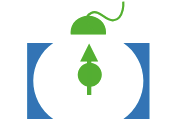

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10,
)

Iteration 0, Loss: 0.599543
Iteration 10, Loss: 0.590846
Iteration 20, Loss: 1.322369
Iteration 30, Loss: 1.272436
Iteration 40, Loss: 0.982990
Iteration 50, Loss: 1.281995
Iteration 60, Loss: 0.631210
Iteration 70, Loss: 1.115545
Iteration 80, Loss: 1.119733
Iteration 90, Loss: 1.202914
Iteration 100, Loss: 0.913810
Iteration 110, Loss: 1.686073
Iteration 120, Loss: 0.853834
Iteration 130, Loss: 1.049071
Iteration 140, Loss: 1.115006
Iteration 150, Loss: 1.419471
Iteration 160, Loss: 1.098718
Iteration 170, Loss: 1.152490
Iteration 180, Loss: 1.695407
Iteration 190, Loss: 0.991887
Iteration 200, Loss: 0.851594
Iteration 210, Loss: 1.197251
Iteration 220, Loss: 1.173014
Iteration 230, Loss: 1.141831
Iteration 240, Loss: 1.055907
Iteration 250, Loss: 0.977759
Iteration 260, Loss: 1.051235
Iteration 270, Loss: 0.843319
Iteration 280, Loss: 0.848811
Iteration 290, Loss: 1.103803
Iteration 300, Loss: 1.166982
Iteration 310, Loss: 0.975486
Iteration 320, Loss: 0.817315
Iteration 330, Loss: 

In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([ 6.40519374e-16, -4.60766923e+00], dtype=float64)], 'lookup_table': [[Array([1.54823643, 0.20729618], dtype=float64), Array([0.41972716, 1.42851726], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64)], [Array([0.77614797, 0.09302298], dtype=float64), Array([0.47469224, 1.27819312], dtype=float64), Array([1.3531041 , 0.98889678], dtype=float64), Array([3.09187163, 2.17670191], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 9.96964987e-01+0.j -2.75876693e-02+0.j -9.18934281e-03+0.j ...
   -7.40919924e-04+0.j -7.35158190e-05+0.j -1.74060566e-03+0.j]
  [-2.75876693e-02+0.j  8.12671230e-04+0.j  2.51300333e-04+0.j ...
    1.92764243e-05+0.j  7.67811869e-07+0.j  5.43415314e-05+0.j]
  [-9.18934281e-03+0.j  2.51300333e-04+0.j  1.04562009e-04+0.j ...
    6.76069958e-06+0.j  1.14161791e-06+0.j  1.20572941e-05+0.j]
  ...
  [-7.40919924e-04+0.j  1.92764243e-05+0.j  6.76069958e-06+0.j ...
    7.47463169e-07+0.j  1.52436730e-07+0.j  9.18133731e-07+0.j]
  [-7.35158190e-05+0.j  7.67811869e-07+0.j  1.14161791e-06+0.j ...
    1.52436730e-07+0.j  1.83056654e-07+0.j -3.22111069e-07+0.j]
  [-1.74060566e-03+0.j  5.43415314e-05+0.j  1.20572941e-05+0.j ...
    9.18133731e-07+0.j -3.22111069e-07+0.j  7.08780374e-06+0.j]]

 [[ 3.13318455e-02+0.j  1.71732518e-02+0.j  1.49274788e-01+0.j ...
   -5.44131404e-03+0.j -6.61081695e-03+0.j -6.24302464e-03+0.j]
  [ 1.71732518e-02+0.j  1.23541561e-02+0.j  1.01156782e-01+0.j ...
   -3.69

In [9]:
# 0.8119213228423314
print(result.final_purity)

0.7958940348811265


In [10]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.9959702744546439
Purity of state 1: 0.9603473977092603
Purity of state 2: 0.8098743907457502
Purity of state 3: 0.9467586439046825
Purity of state 4: 0.8098743907457502
Purity of state 5: 0.7830009318779882
Purity of state 6: 0.9817522017268371
Purity of state 7: 0.9959702744546439
Purity of state 8: 0.2970933425792209
Purity of state 9: 0.3782985006124865


In [11]:
result.returned_params

[[Array([[ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00]], dtype=float64)],
 [Array([[1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618]], dtype=float64)],
 [Array([[0.77614797, 0.09302298],
         [0.77614797, 0.09302298],
         [0.47469224, 1.27819312],
         [0.47469224, 1.27819312],
         [0.47469224, 1.

In [12]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [13]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 6.40519374e-16 -4.60766923e+00]
purity of rho after time step 0 0.20000208604889952
params for time step 1: [1.54823643 0.20729618]
purity of rho after time step 1 0.37860914118354183
params for time step 2: [0.77614797 0.09302298]
purity of rho after time step 2 0.3624641132923659
params for time step 3: [1.1721827  0.07046644]
purity of rho after time step 3 0.3535876227441456
params for time step 4: [0.97901875 0.03451424]
purity of rho after time step 4 0.4311761211460467


In [14]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [15]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 1.32533735e-04+0.j  5.61857796e-03+0.j  1.93571761e-04+0.j
   2.29591688e-04+0.j  5.27616767e-05+0.j  2.21639810e-03+0.j
  -5.24690450e-05+0.j  5.01436338e-05+0.j  4.65323810e-05+0.j
  -5.20357771e-05+0.j -9.96039181e-06+0.j -7.25245735e-05+0.j
  -1.07888983e-05+0.j  1.41626117e-05+0.j -3.50064917e-06+0.j
  -6.09489899e-05+0.j -1.31092439e-05+0.j -4.04294756e-05+0.j
  -1.31220515e-05+0.j  7.94785132e-06+0.j -1.56016178e-05+0.j
  -1.16560055e-04+0.j -1.47211239e-05+0.j -1.94426328e-05+0.j
  -7.10417735e-05+0.j  1.92636924e-05+0.j -6.77793256e-06+0.j
   3.77529201e-05+0.j -4.05358846e-06+0.j -1.73293671e-05+0.j]
 [ 5.61857796e-03+0.j  2.98092931e-01+0.j  6.78419441e-03+0.j
  -3.11331985e-03+0.j -2.47982313e-04+0.j  1.51868220e-02+0.j
   2.66838855e-04+0.j  1.53743006e-03+0.j  3.40468021e-03+0.j
  -2.10528412e-03+0.j  1.05095650e-04+0.j -3.71417161e-03+0.j
  -2.23384444e-04+0.j  6.23312074e-04+0.j  4.19997541e-04+0.j
  -2.57860872e-03+0.j -4

In [16]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 9.96964987e-01+0.j -2.75876693e-02+0.j -9.18934281e-03+0.j ...
   -7.40919924e-04+0.j -7.35158190e-05+0.j -1.74060566e-03+0.j]
  [-2.75876693e-02+0.j  8.12671230e-04+0.j  2.51300333e-04+0.j ...
    1.92764243e-05+0.j  7.67811869e-07+0.j  5.43415314e-05+0.j]
  [-9.18934281e-03+0.j  2.51300333e-04+0.j  1.04562009e-04+0.j ...
    6.76069958e-06+0.j  1.14161791e-06+0.j  1.20572941e-05+0.j]
  ...
  [-7.40919924e-04+0.j  1.92764243e-05+0.j  6.76069958e-06+0.j ...
    7.47463169e-07+0.j  1.52436730e-07+0.j  9.18133731e-07+0.j]
  [-7.35158190e-05+0.j  7.67811869e-07+0.j  1.14161791e-06+0.j ...
    1.52436730e-07+0.j  1.83056654e-07+0.j -3.22111069e-07+0.j]
  [-1.74060566e-03+0.j  5.43415314e-05+0.j  1.20572941e-05+0.j ...
    9.18133731e-07+0.j -3.22111069e-07+0.j  7.08780374e-06+0.j]]

 [[ 3.13318455e-02+0.j  1.71732518e-02+0.j  1.49274788e-01+0.j ...
   -5.44131404e-03+0.j -6.61081695e-03+0.j -6.24302464e-03+0.j]
  [ 1.71732518e-02+0.j  1.23541561e-02+0.j  1.0115

In [17]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [18]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [19]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [20]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [21]:
batch_size = 2

In [22]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [23]:
rho_final_batched.shape

(2, 30, 30)

In [24]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [25]:
rng_keys[0].shape

(2,)

In [26]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]
